In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [2]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

--------
# Gather data

In [3]:
zbest_path = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/denali/testdenali/All/alltiles_Allzinfo.fits'
zbest_columns = ['TARGETID', 'CHI2', 'Z', 'ZERR', 'ZWARN', 'SPECTYPE', 'SUBTYPE', 'DELTACHI2', 'PETAL_LOC', 'DEVICE_LOC', 'LOCATION', 'FIBER', 'FIBERSTATUS', 'TARGET_RA', 'TARGET_DEC', 'PMRA', 'PMDEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'GAIA_PHOT_G_MEAN_MAG', 'EBV', 'FLUX_W1', 'FLUX_W2', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_Z', 'MASKBITS', 'SERSIC', 'PHOTSYS', 'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 'SV1_MWS_TARGET', 'TILEID', 'COADD_NUMEXP', 'COADD_EXPTIME', 'EXPS', 'TSNR2_ELG', 'TSNR2_BGS', 'TSNR2_QSO', 'TSNR2_LRG', 'EFFTIME_DARK', 'EFFTIME_BRIGHT', 'EFFTIME_BACK', 'coadd_type', 'TARGETS', 'FIRST_EXPID', 'subset']

tmp = Table(fitsio.read(zbest_path, columns=['SV1_DESI_TARGET', 'TARGETS', 'coadd_type']))
mask = (tmp['SV1_DESI_TARGET'] & 2**0 > 0) & (tmp['TARGETS']=='QSO+LRG') & (tmp['coadd_type']!='pernight')
idx = np.where(mask)[0]

zbest = Table(fitsio.read(zbest_path, columns=zbest_columns, rows=idx))
print(len(zbest))
print(len(np.unique(zbest['TARGETID'])))

581288
52023


In [4]:
deep = zbest.copy()

# Select deep coadds
mask = deep['coadd_type']=='cumulative'
print(np.sum(mask))
# # Select QSO+LRG tiles
# mask &= deep['TARGETS']=='QSO+LRG'
# print(np.sum(mask))
deep = deep[mask]

# Remove FIBERSTATUS!=0 fibers
mask = deep['FIBERSTATUS']==0
print('FIBERSTATUS',np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
deep = deep[mask]

# Remove "no data" fibers
mask = deep['ZWARN'] & 2**9==0
print('No data', np.sum(mask), np.sum(~mask), np.sum(~mask)/len(mask))
deep = deep[mask]

# Require a minimum depth for the deep coadd
min_depth = 3000.
mask = deep['EFFTIME_DARK']>min_depth
print('Min depth', np.sum(mask), np.sum(~mask), np.sum(mask)/len(mask))
deep = deep[mask]

# WISE masks
maskbits = [8, 9]
mask_clean = np.ones(len(deep), dtype=bool)
for bit in maskbits:
    mask_clean &= (deep['MASKBITS'] & 2**bit)==0
print('MASKBITS', np.sum(mask_clean), np.sum(~mask_clean), np.sum(mask_clean)/len(mask_clean))
deep = deep[mask_clean]

52268
FIBERSTATUS 43371 8897 0.17021887196755184
No data 43368 3 6.917064397869545e-05
Min depth 31466 11902 0.7255580151263604
MASKBITS 30218 1248 0.9603381427572618


In [5]:
print(len(deep))
print(len(np.unique(deep['TARGETID'])))

deep_columns_old = ['Z', 'ZERR', 'ZWARN', 'SPECTYPE', 'SUBTYPE', 'DELTACHI2', 'EFFTIME_DARK', 'EFFTIME_BRIGHT', 'EFFTIME_BACK']
deep_columns_new = ['Z_deep', 'ZERR_deep', 'ZWARN_deep', 'SPECTYPE_deep', 'SUBTYPE_deep', 'DELTACHI2_deep', 'EFFTIME_DARK_deep', 'EFFTIME_BRIGHT_deep', 'EFFTIME_BACK_deep']
deep.rename_columns(deep_columns_old, deep_columns_new)

30218
30161


In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    deep['gmag'] = 22.5 - 2.5*np.log10(deep['FLUX_G']) - 3.214 * deep['EBV']
    deep['rmag'] = 22.5 - 2.5*np.log10(deep['FLUX_R']) - 2.165 * deep['EBV']
    deep['zmag'] = 22.5 - 2.5*np.log10(deep['FLUX_Z']) - 1.211 * deep['EBV']
    deep['w1mag'] = 22.5 - 2.5*np.log10(deep['FLUX_W1']) - 0.184 * deep['EBV']
    deep['w2mag'] = 22.5 - 2.5*np.log10(deep['FLUX_W2']) - 0.113 * deep['EBV']
    deep['rfibermag'] = 22.5 - 2.5*np.log10(deep['FIBERFLUX_R']) - 2.165 * deep['EBV']
    deep['zfibermag'] = 22.5 - 2.5*np.log10(deep['FIBERFLUX_Z']) - 1.211 * deep['EBV']

In [7]:
mask = zbest['coadd_type']=='perexp'
zbest = zbest[mask]
print(len(zbest))

zbest['EXPID'] = np.array(np.char.replace(zbest['subset'], 'exp', ''), dtype=int)

mask = np.in1d(zbest['TARGETID'], deep['TARGETID'])
zbest = zbest[mask]
print(len(zbest))

print(len(np.unique(zbest['TARGETID'])))

deep_columns = deep_columns_new+['TARGETID', 'gmag', 'rmag', 'zmag', 'w1mag', 'w2mag', 'rfibermag', 'zfibermag']
zbest = join(zbest, deep[deep_columns], keys='TARGETID')

529020
375540
30161


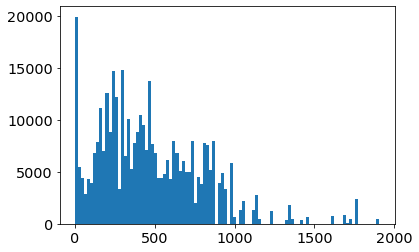

In [8]:
plt.hist(zbest['EFFTIME_DARK'], 100)
plt.show()

--------

In [9]:
# Not repeatable
zdiff_threshold = 0.0033
mask_fail = np.abs((zbest['Z'] - zbest['Z_deep'])/(1 + zbest['Z_deep'])) > zdiff_threshold
print(np.sum(mask_fail), np.sum(mask_fail)/len(mask_fail))
# Also reject objects with ZWARN!=0 or z>1.4 or DELTACHI2<15 in the deep coadds
mask_deep = (zbest['ZWARN_deep']==0) & (zbest['Z_deep']<1.4)
# mask_deep = (zbest['ZWARN_deep']==0) & (zbest['Z_deep']<1.4) & (zbest['DELTACHI2_deep']>30)
mask_fail |= (~mask_deep)
print(np.sum(mask_fail), np.sum(mask_fail)/len(mask_fail))

104375 0.27705665626128134
106039 0.28147363615128157


In [10]:
mask_quality = zbest['ZWARN']==0
mask_quality &= zbest['Z']<1.4
mask_quality &= zbest['DELTACHI2']>15

# Custom DELTACHI2 vs z cut
d = (10**(3 - 3.5*zbest['Z']))
mask_remove = (d>30) & (zbest['DELTACHI2']<30)
mask_remove |= (d<30) & (zbest['DELTACHI2']<d)
mask_remove |= (zbest['DELTACHI2']<10)
mask_quality1 = zbest['ZWARN']==0
mask_quality1 &= zbest['Z']<1.4
mask_quality1 &= (~mask_remove)

-------
# Apply the new LRG selection

In [11]:
gmag = zbest['gmag']
rmag = zbest['rmag']
zmag = zbest['zmag']
w1mag = zbest['w1mag']
w2mag = zbest['w2mag']
rfibermag = zbest['rfibermag']
zfibermag = zbest['zfibermag']
gaia_g = zbest['GAIA_PHOT_G_MEAN_MAG']

mask_north = zbest['PHOTSYS']=='N'
mask_south = zbest['PHOTSYS']=='S'

In [12]:
# mask_north = zbest['PHOTSYS']=='N'
# mask_south = zbest['PHOTSYS']=='S'

# South
lrg_mask = mask_south.copy()
lrg_mask &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.6)                   # faint limit

lrg_mask_sliding = rmag - w1mag > (w1mag - 17.14) * 1.8  # sliding IR cut
lrg_mask_sliding &= rmag - w1mag > (w1mag - 16.33) * 1.  # low-z sliding IR cut
lrg_mask_sliding |= rmag - w1mag > 3.3
lrg_mask &= lrg_mask_sliding

mask_lowz = gmag - w1mag > 2.9  # low-z cut
mask_lowz |= rmag - w1mag > 1.8  # low-z cut
lrg_mask &= mask_lowz

mask_bright = (gaia_g!=0) & (gaia_g < 18)
lrg_mask &= (~mask_bright)

# lrg_mask &= (zfibertotmag>17.5)

lrg_new_south = lrg_mask.copy()

# North
lrg_mask = mask_north.copy()
lrg_mask &= zmag - w1mag > 0.8 * (rmag - zmag) - 0.6  # non-stellar cut
lrg_mask &= (zfibermag < 21.61)                   # faint limit

lrg_mask_sliding = rmag - w1mag > (w1mag - 17.13) * 1.83  # sliding IR cut
lrg_mask_sliding &= rmag - w1mag > (w1mag - 16.31) * 1.   # low-z sliding IR cut
lrg_mask_sliding |= rmag - w1mag > 3.4
lrg_mask &= lrg_mask_sliding

mask_lowz = gmag - w1mag > 2.97  # low-z cut
mask_lowz |= rmag - w1mag > 1.8  # low-z cut
lrg_mask &= mask_lowz

mask_bright = (gaia_g!=0) & (gaia_g < 18)
lrg_mask &= (~mask_bright)

# lrg_mask &= (zfibertotmag>17.5)

lrg_new_north = lrg_mask.copy()

lrg_new = lrg_new_south | lrg_new_north
print(np.sum(lrg_new))

104298


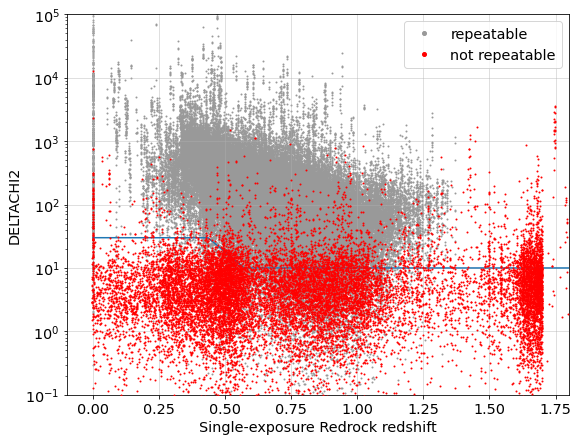

In [13]:
x = np.linspace(0, 2, 10000)
y = np.ones_like(x)
y = (10**(3 - 3.5*x))
y[y<10] = 10
y[y>30] = 30

plt.figure(figsize=(9, 7))
plt.plot(zbest['Z'][lrg_new & (~mask_fail)], zbest['DELTACHI2'][lrg_new & (~mask_fail)], '.', color='0.6', ms=2, alpha=1, label='repeatable', zorder=1)
plt.plot(zbest['Z'][lrg_new & mask_fail], zbest['DELTACHI2'][lrg_new & mask_fail], 'r.', ms=2, alpha=1, label='not repeatable', zorder=10)
plt.plot(x, y)
# plt.axhline(9., ls='--', color='0.6', label='ZWARN threshold')
plt.yscale('log')
plt.xlabel('Single-exposure Redrock redshift')
plt.ylabel('DELTACHI2')
plt.axis([-0.1, 1.8, .1, 100000])
plt.legend(markerscale=4, loc='upper right')
plt.grid(alpha=0.5)
plt.show()

In [14]:
def binned_frac(x, y, bin_edges, minsize=10):
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    bin_frac = np.zeros(len(bin_edges)-1)
    bin_frac_err = np.zeros(len(bin_edges)-1)
    for index in range(len(bin_edges)-1):
        mask = (x>bin_edges[index]) & (x<=bin_edges[index+1])
        if np.sum(mask)<minsize:
            bin_frac[index] = np.nan
            bin_frac_err[index] = np.nan
        else:
            n, p = np.sum(mask), np.mean(y[mask])
            p1 = np.maximum(p, 1/n)  # error floor
            bin_frac[index] = p
            bin_frac_err[index] = np.clip(np.sqrt(n * p * (1-p))/n, np.sqrt(n * p1 * (1-p1))/n, 1)
    
    return bin_center, bin_frac, bin_frac_err

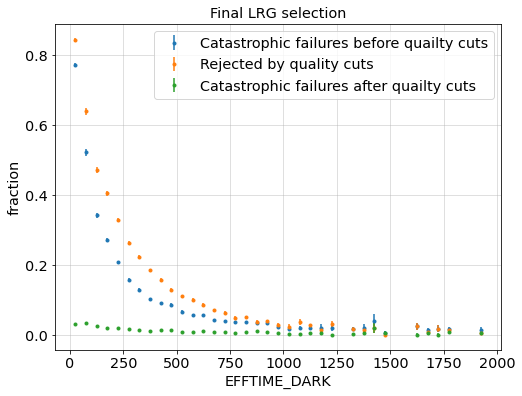

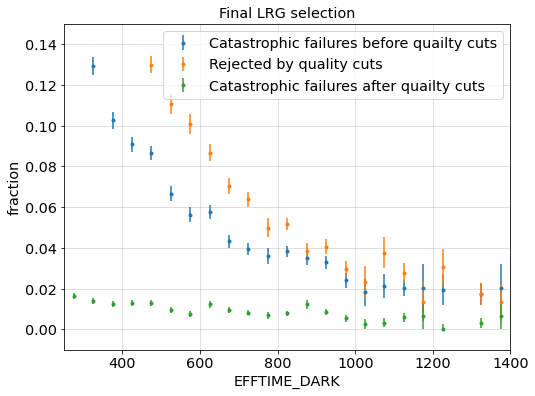

In [15]:
mask = lrg_new.copy()
bin_edges = np.linspace(0, 2000, 41)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(zbest['EFFTIME_DARK'][mask], (~mask_quality)[mask], bin_edges, minsize=10)
bin_center, bin_fail_rate, bin_fail_rate_err = binned_frac(zbest['EFFTIME_DARK'][mask], mask_fail[mask], bin_edges, minsize=10)
bin_center, bin_still_fail_rate, bin_still_fail_rate_err = binned_frac(zbest['EFFTIME_DARK'][mask], (mask_quality & mask_fail)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_fail_rate,
             yerr=(np.clip(bin_fail_rate_err, None, bin_fail_rate), bin_fail_rate_err),
             fmt='.', label='Catastrophic failures before quailty cuts')
plt.errorbar(bin_center, bin_reject_rate,
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='Rejected by quality cuts')
plt.errorbar(bin_center, bin_still_fail_rate,
             yerr=(np.clip(bin_still_fail_rate_err, None, bin_still_fail_rate), bin_still_fail_rate_err),
             fmt='.', label='Catastrophic failures after quailty cuts')
plt.xlabel('EFFTIME_DARK')
plt.ylabel('fraction')
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
plt.title('Final LRG selection')
plt.show()

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_fail_rate,
             yerr=(np.clip(bin_fail_rate_err, None, bin_fail_rate), bin_fail_rate_err),
             fmt='.', label='Catastrophic failures before quailty cuts')
plt.errorbar(bin_center, bin_reject_rate,
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='Rejected by quality cuts')
plt.errorbar(bin_center, bin_still_fail_rate,
             yerr=(np.clip(bin_still_fail_rate_err, None, bin_still_fail_rate), bin_still_fail_rate_err),
             fmt='.', label='Catastrophic failures after quailty cuts')
plt.xlabel('EFFTIME_DARK')
plt.ylabel('fraction')
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
plt.title('Final LRG selection')
plt.axis([250, 1400, -0.01, 0.15])
plt.show()

__Custom DELTACHI2 vs z cut__

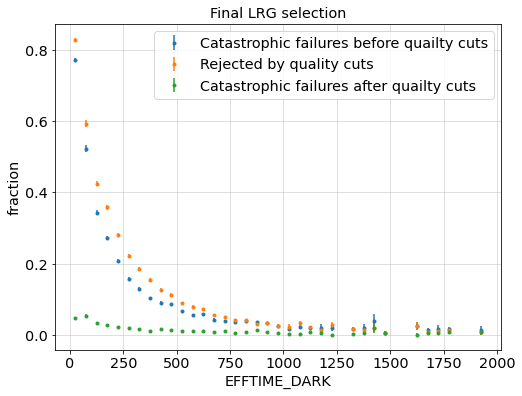

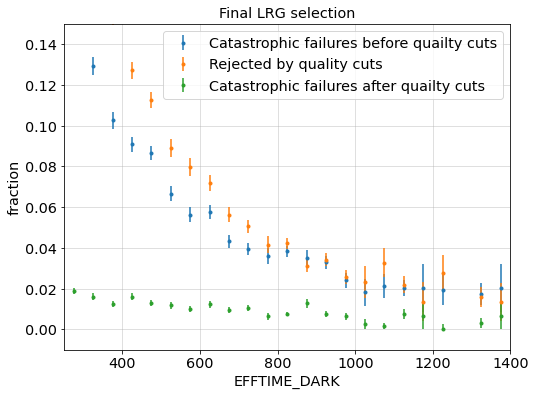

In [16]:
mask = lrg_new.copy()
bin_edges = np.linspace(0, 2000, 41)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(zbest['EFFTIME_DARK'][mask], (~mask_quality1)[mask], bin_edges, minsize=10)
bin_center, bin_fail_rate, bin_fail_rate_err = binned_frac(zbest['EFFTIME_DARK'][mask], mask_fail[mask], bin_edges, minsize=10)
bin_center, bin_still_fail_rate, bin_still_fail_rate_err = binned_frac(zbest['EFFTIME_DARK'][mask], (mask_quality1 & mask_fail)[mask], bin_edges, minsize=10)

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_fail_rate,
             yerr=(np.clip(bin_fail_rate_err, None, bin_fail_rate), bin_fail_rate_err),
             fmt='.', label='Catastrophic failures before quailty cuts')
plt.errorbar(bin_center, bin_reject_rate,
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='Rejected by quality cuts')
plt.errorbar(bin_center, bin_still_fail_rate,
             yerr=(np.clip(bin_still_fail_rate_err, None, bin_still_fail_rate), bin_still_fail_rate_err),
             fmt='.', label='Catastrophic failures after quailty cuts')
plt.xlabel('EFFTIME_DARK')
plt.ylabel('fraction')
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
plt.title('Final LRG selection')
plt.show()

plt.figure(figsize=(8, 6))
plt.errorbar(bin_center, bin_fail_rate,
             yerr=(np.clip(bin_fail_rate_err, None, bin_fail_rate), bin_fail_rate_err),
             fmt='.', label='Catastrophic failures before quailty cuts')
plt.errorbar(bin_center, bin_reject_rate,
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='Rejected by quality cuts')
plt.errorbar(bin_center, bin_still_fail_rate,
             yerr=(np.clip(bin_still_fail_rate_err, None, bin_still_fail_rate), bin_still_fail_rate_err),
             fmt='.', label='Catastrophic failures after quailty cuts')
plt.xlabel('EFFTIME_DARK')
plt.ylabel('fraction')
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
plt.title('Final LRG selection')
plt.axis([250, 1400, -0.01, 0.15])
plt.show()

-------
# Curve fitting

In [17]:
mask = lrg_new.copy()
bin_edges = np.linspace(0, 2000, 41)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(zbest['EFFTIME_DARK'][mask], (~mask_quality)[mask], bin_edges, minsize=10)
bin_center, bin_fail_rate, bin_fail_rate_err = binned_frac(zbest['EFFTIME_DARK'][mask], mask_fail[mask], bin_edges, minsize=10)
bin_center, bin_still_fail_rate, bin_still_fail_rate_err = binned_frac(zbest['EFFTIME_DARK'][mask], (mask_quality & mask_fail)[mask], bin_edges, minsize=10)

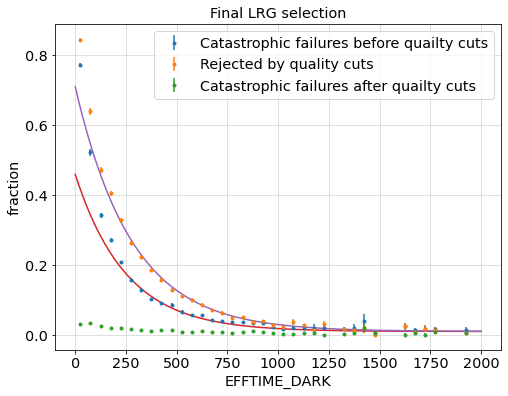

In [18]:
plt.figure(figsize=(8, 6))

x = np.linspace(0, 2000, 1000)
y = np.exp(-(x+200)/250)+0.01
y1 = np.exp(-(x+100)/280)+0.01

plt.errorbar(bin_center, bin_fail_rate,
             yerr=(np.clip(bin_fail_rate_err, None, bin_fail_rate), bin_fail_rate_err),
             fmt='.', label='Catastrophic failures before quailty cuts')
plt.errorbar(bin_center, bin_reject_rate,
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='Rejected by quality cuts')
plt.errorbar(bin_center, bin_still_fail_rate,
             yerr=(np.clip(bin_still_fail_rate_err, None, bin_still_fail_rate), bin_still_fail_rate_err),
             fmt='.', label='Catastrophic failures after quailty cuts')

plt.plot(x, y)
plt.plot(x, y1)

plt.xlabel('EFFTIME_DARK')
plt.ylabel('fraction')
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
plt.title('Final LRG selection')
# plt.axis([-50, 1400, 0, .7])
# plt.axis([250, 1400, -0.01, 0.2])
plt.show()

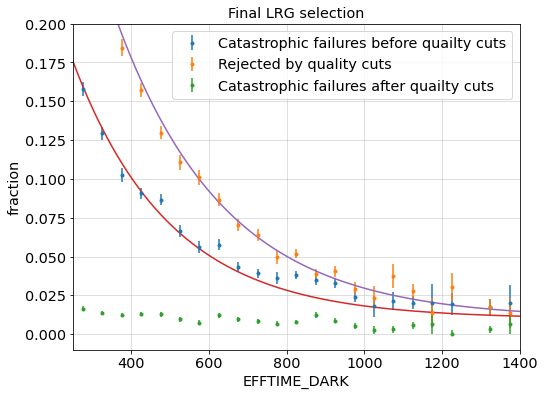

In [19]:
plt.figure(figsize=(8, 6))

x = np.linspace(0, 2000, 1000)
y = np.exp(-(x+200)/250)+0.01
y1 = np.exp(-(x+100)/280)+0.01

plt.errorbar(bin_center, bin_fail_rate,
             yerr=(np.clip(bin_fail_rate_err, None, bin_fail_rate), bin_fail_rate_err),
             fmt='.', label='Catastrophic failures before quailty cuts')
plt.errorbar(bin_center, bin_reject_rate,
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='Rejected by quality cuts')
plt.errorbar(bin_center, bin_still_fail_rate,
             yerr=(np.clip(bin_still_fail_rate_err, None, bin_still_fail_rate), bin_still_fail_rate_err),
             fmt='.', label='Catastrophic failures after quailty cuts')

plt.plot(x, y)
plt.plot(x, y1)

plt.xlabel('EFFTIME_DARK')
plt.ylabel('fraction')
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
plt.title('Final LRG selection')
# plt.axis([-50, 1400, 0, .7])
plt.axis([250, 1400, -0.01, 0.2])
plt.show()

In [20]:
x = 900
print(np.exp(-(x+100)/280)+0.01, (np.exp(-(x+100)/280)+0.01)*609.2)

x = 1100
print(np.exp(-(x+100)/280)+0.01, (np.exp(-(x+100)/280)+0.01)*609.2)

0.03811565974897203 23.220059919073766
0.0237637867330504 14.476898877774305


__Custom DELTACHI2 vs z cut__

In [21]:
mask = lrg_new.copy()
bin_edges = np.linspace(0, 2000, 41)
bin_center, bin_reject_rate, bin_reject_rate_err = binned_frac(zbest['EFFTIME_DARK'][mask], (~mask_quality1)[mask], bin_edges, minsize=10)
bin_center, bin_fail_rate, bin_fail_rate_err = binned_frac(zbest['EFFTIME_DARK'][mask], mask_fail[mask], bin_edges, minsize=10)
bin_center, bin_still_fail_rate, bin_still_fail_rate_err = binned_frac(zbest['EFFTIME_DARK'][mask], (mask_quality1 & mask_fail)[mask], bin_edges, minsize=10)

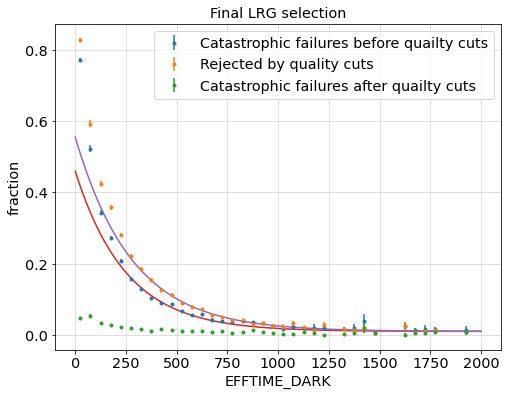

In [22]:
plt.figure(figsize=(8, 6))

x = np.linspace(0, 2000, 1000)
y = np.exp(-(x+200)/250)+0.01
y1 = np.exp(-(x+170)/280)+0.01

plt.errorbar(bin_center, bin_fail_rate,
             yerr=(np.clip(bin_fail_rate_err, None, bin_fail_rate), bin_fail_rate_err),
             fmt='.', label='Catastrophic failures before quailty cuts')
plt.errorbar(bin_center, bin_reject_rate,
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='Rejected by quality cuts')
plt.errorbar(bin_center, bin_still_fail_rate,
             yerr=(np.clip(bin_still_fail_rate_err, None, bin_still_fail_rate), bin_still_fail_rate_err),
             fmt='.', label='Catastrophic failures after quailty cuts')

plt.plot(x, y)
plt.plot(x, y1)

plt.xlabel('EFFTIME_DARK')
plt.ylabel('fraction')
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
plt.title('Final LRG selection')
# plt.axis([-50, 1400, 0, .7])
# plt.axis([250, 1400, -0.01, 0.2])
plt.show()

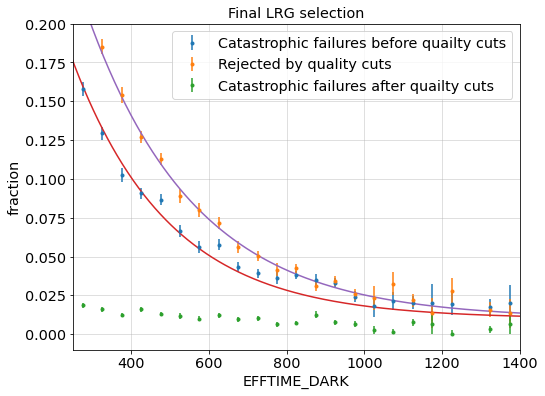

In [23]:
plt.figure(figsize=(8, 6))

x = np.linspace(0, 2000, 1000)
y = np.exp(-(x+200)/250)+0.01
y1 = np.exp(-(x+170)/280)+0.01

plt.errorbar(bin_center, bin_fail_rate,
             yerr=(np.clip(bin_fail_rate_err, None, bin_fail_rate), bin_fail_rate_err),
             fmt='.', label='Catastrophic failures before quailty cuts')
plt.errorbar(bin_center, bin_reject_rate,
             yerr=(np.clip(bin_reject_rate_err, None, bin_reject_rate), bin_reject_rate_err),
             fmt='.', label='Rejected by quality cuts')
plt.errorbar(bin_center, bin_still_fail_rate,
             yerr=(np.clip(bin_still_fail_rate_err, None, bin_still_fail_rate), bin_still_fail_rate_err),
             fmt='.', label='Catastrophic failures after quailty cuts')

plt.plot(x, y)
plt.plot(x, y1)

plt.xlabel('EFFTIME_DARK')
plt.ylabel('fraction')
plt.grid(alpha=0.5)
plt.legend(loc='upper right')
plt.title('Final LRG selection')
# plt.axis([-50, 1400, 0, .7])
plt.axis([250, 1400, -0.01, 0.2])
plt.show()

In [24]:
x = 900
print(np.exp(-(x+170)/280)+0.01, (np.exp(-(x+170)/280)+0.01)*609.2)

x = 1100
print(np.exp(-(x+170)/280)+0.01, (np.exp(-(x+170)/280)+0.01)*609.2)

0.0318964978290686 19.431346477468594
0.020719247885727467 12.622165811985173
